### Data Cleaning

## Load the Data

In [1]:
'''
import pandas as pd

df = pd.read_csv("reddit_food_delivery_sentiments.csv")
df.head()
'''


'\nimport pandas as pd\n\ndf = pd.read_csv("reddit_food_delivery_sentiments.csv")\ndf.head()\n'

## Load data (if using google drive in google collab)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

file_path = '/content/drive/My Drive/reddit_food_delivery_sentiments.csv' #file path in google drive
df = pd.read_csv(file_path)
df.head()


,title,text,comments,date,score,num_comments,created_utc,subreddit,keyword,url
0,Is this normal?,Bought the Popcorn Chicken+Fries+Lemonade from...,Yeah never buying from that restaurant or what...,26/4/2025,227,88.0,1745675485,malaysia,foodpanda,https://i.redd.it/xz7e8glgp6xe1.png
1,Foodpanda Bicycle Rider Question,"Greetings all,\n\nI am looking for specific in...",Hi I used to do foodpanda walker during mco. ...,14/4/2025,0,2.0,1744617428,malaysia,foodpanda,https://www.reddit.com/r/malaysia/comments/1jy...
2,Foodpanda wants you to BEG for refunds,I know there are still a lot of Foodpanda user...,"Stop using foodpanda, shoppeefood is currently...",30/3/2025,20,42.0,1743301789,malaysia,foodpanda,https://www.reddit.com/r/malaysia/comments/1jn...
3,Cancelled my order on FoodPanda and Still didn...,NaN,Pretty sure this falls under KPDNHEP authority...,27/2/2025,30,13.0,1740625211,malaysia,foodpanda,https://i.redd.it/opdl0osaklle1.png
4,Foodpanda vs grab vs shopeefood,NaN,using all 3.\n\nshopeefood - when wanna buy fr...,21/1/2025,0,1.0,1737485781,malaysia,foodpanda,/r/MalaysianFood/comments/1i6l1e4/foodpanda_vs...


## Initial Cleaning

In [4]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Drop rows with no useful text
df.dropna(subset=['title', 'text', 'comments'], how='all', inplace=True)

# Combine all relevant text into a single column
df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('') + ' ' + df['comments'].fillna('')


## Filter Irrelevant Posts

In [5]:
relevant_keywords = ['foodpanda', 'grabfood', 'shopeefood', 'delivery', 'rider', 'order', 'late', 'service', 'food', 'refund', 'time', 'slow']

df = df[df['content'].str.contains('|'.join(relevant_keywords), case=False, na=False)]


## Language Translation (Malay to English)
BERT typically works best with English

In [6]:
!pip install deep-translator
from deep_translator import GoogleTranslator

def translate_text(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except:
        return text  # return original if error occurs

# Warning: this can be slow and rate-limited
df['translated'] = df['content'].apply(translate_text)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.6 MB/s eta 0:00:00


## Advanced Cleaning

In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)  # Remove mentions and hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove digits
    text = text.lower().strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['translated'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Profanity Handling

In [8]:
!pip install better-profanity
from better_profanity import profanity
profanity.load_censor_words()

df['contains_profanity'] = df['cleaned_text'].apply(lambda x: profanity.contains_profanity(x))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.3 MB/s eta 0:00:00


## Tokenization
Breaking text into words or subwords (tokens), required for model input (BERT).

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example tokenization
df['tokens'] = df['cleaned_text'].apply(lambda x: tokenizer.tokenize(x))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Export the clean .csv file

In [10]:
'''
# Save cleaned dataframe
df['cleaned_text'].to_csv('cleaned_reddit_data.csv', index=False)
'''


###  Load and use a pretrained ABSA model.

## Install transformers and import model
model source: yangheng/deberta-v3-base-absa-v1.1 (hugging face)

In [11]:
!pip install transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load pretrained ABSA model
model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline
absa_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Device set to use cuda:0


## Add a related_ofd column to your cleaned DataFrame (for  comparative visualizations.)

In [22]:
def detect_ofd(text):
    if isinstance(text, str):
        text = text.lower()
        if 'foodpanda' in text:
            return 'foodpanda'
        elif 'grabfood' in text:
            return 'grabfood'
        elif 'shopeefood' in text or 'shopee food' in text:
            return 'shopeefood'
    return 'unknown'



In [23]:
df['related_ofd'] = df['cleaned_text'].apply(detect_ofd)


In [24]:
df['related_ofd'].value_counts()


,count
related_ofd,
foodpanda,223
unknown,157
grabfood,57
shopeefood,19


## Filter out unrelated posts

In [29]:
# Filter the DataFrame to only include posts related to an OFD
df_filtered = df[df['related_ofd'] != 'unknown'].copy()


## Save the filtered data

In [30]:
df_filtered.to_csv('cleaned_filtered_reddit_data.csv', index=False)


## Create and Run ABSA Predictions

In [49]:
# Define aspects
aspects = ['delivery time', 'app experience', 'food quality', 'correctness of order', 'price']

# Process entire dataset
df_subset = df_filtered

# Create results container
results = []

# Loop through each post and each aspect
for _, row in df_subset.iterrows():
    text = row['cleaned_text']
    row_result = {'original_text': text}

    for aspect in aspects:
        formatted = f"{aspect} aspect: {text}"
        try:
            prediction = absa_pipeline(formatted)[0]
            row_result[f"{aspect}_sentiment"] = prediction['label']
            row_result[f"{aspect}_score"] = prediction['score']
        except Exception as e:
            row_result[f"{aspect}_sentiment"] = "error"
            row_result[f"{aspect}_score"] = 0
            print(f"⚠️ Error on '{aspect}' for text: {text}\n{e}")

    results.append(row_result)



## Convert Predictions to DataFrame

In [50]:
absa_df = pd.DataFrame(results)

# Show sample
absa_df.head()


,original_text,delivery time_sentiment,delivery time_score,app experience_sentiment,app experience_score,food quality_sentiment,food quality_score,correctness of order_sentiment,correctness of order_score,price_sentiment,price_score
0,normal bought popcorn chickenfrieslemonade pop...,Negative,0.846438,Negative,0.798995,Negative,0.859453,Negative,0.765265,Negative,0.928972
1,foodpanda bicycle rider question greetings loo...,Positive,0.721928,Positive,0.675697,Positive,0.629673,Positive,0.797865,Positive,0.626980
2,foodpanda wants beg refunds know still lot foo...,Negative,0.951767,Negative,0.949882,Negative,0.949486,Negative,0.950221,Negative,0.950975
3,cancelled order foodpanda still didnt get refu...,Negative,0.906285,Negative,0.887314,Negative,0.895096,Negative,0.867766,Negative,0.891187
4,foodpanda vs grab vs shopeefood using shopeefo...,Negative,0.791804,Neutral,0.775390,Negative,0.653646,Negative,0.459286,Negative,0.498327


## Save the ABSA results to CSV

In [51]:
# Ensure lengths match before merging
absa_df['related_ofd'] = df_subset['related_ofd'].values

# Save to CSV with OFD classification
absa_df.to_csv("absa_results_filtered_comparison.csv", index=False)


##  Load the CSV and install required libraries for visualisation testing

In [52]:
!pip install matplotlib seaborn wordcloud

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np



In [53]:
# Load the data
absa_df = pd.read_csv("absa_results_filtered_comparison.csv")



## Bar Plot – Sentiment Count per Aspect

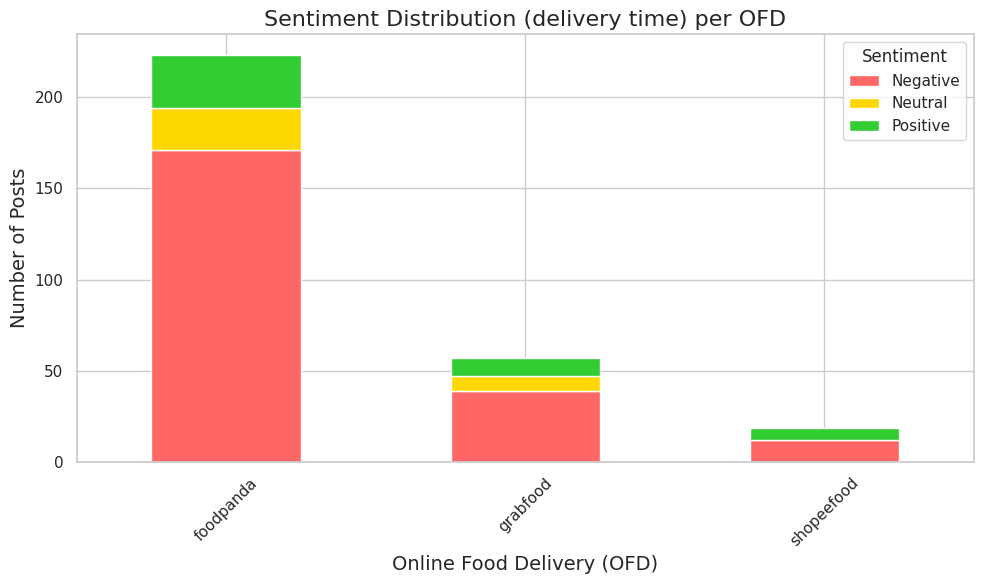

In [55]:
# Group by 'related_ofd' and sentiment
sentiment_counts = absa_df.groupby(['related_ofd', 'delivery time_sentiment']).size().unstack(fill_value=0)

# Plot bar graph
sentiment_counts.plot(kind='bar', stacked=True, figsize=(10,6), color=['#FF6666', '#FFD700', '#32CD32'])
plt.title('Sentiment Distribution (delivery time) per OFD', fontsize=16)
plt.xlabel('Online Food Delivery (OFD)', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
plt.tight_layout()
plt.show()


## Pie Charts – Sentiment Distribution per Aspect

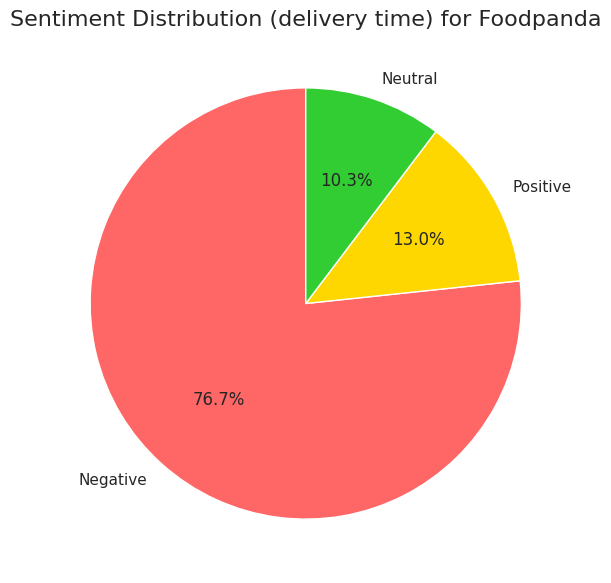

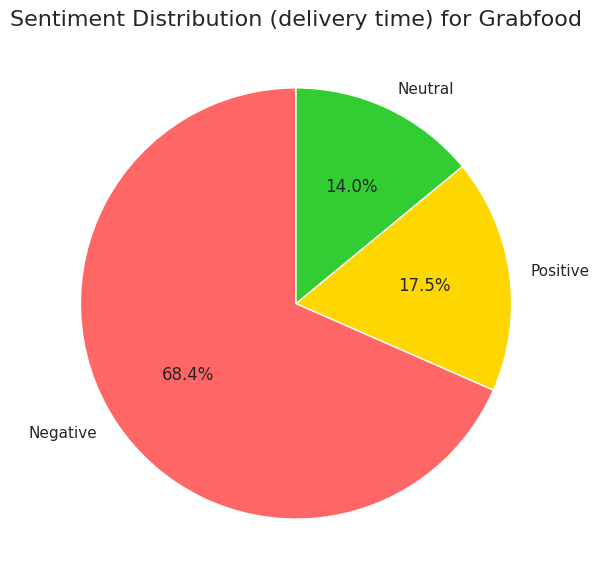

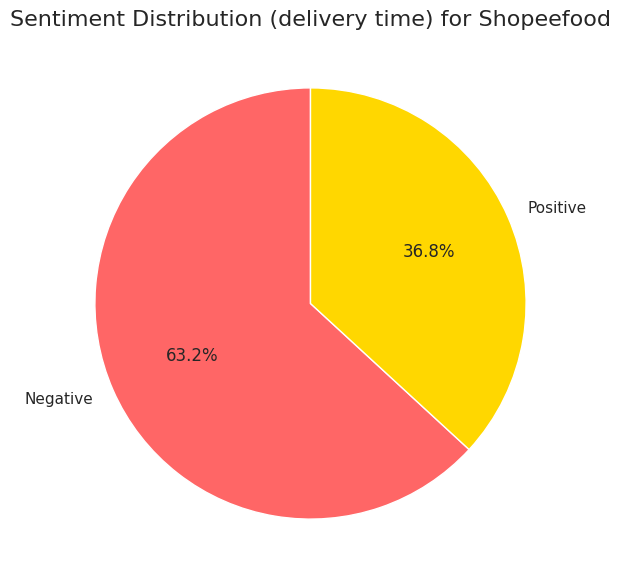

In [56]:
# Create a pie chart for each OFD
ofds = ['foodpanda', 'grabfood', 'shopeefood']

for ofd in ofds:
    ofd_data = absa_df[absa_df['related_ofd'] == ofd]
    sentiment_counts = ofd_data['delivery time_sentiment'].value_counts()

    plt.figure(figsize=(7,7))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#FF6666', '#FFD700', '#32CD32'])
    plt.title(f'Sentiment Distribution (delivery time) for {ofd.capitalize()}', fontsize=16)
    plt.show()



## Word Cloud – Common Words in Posts

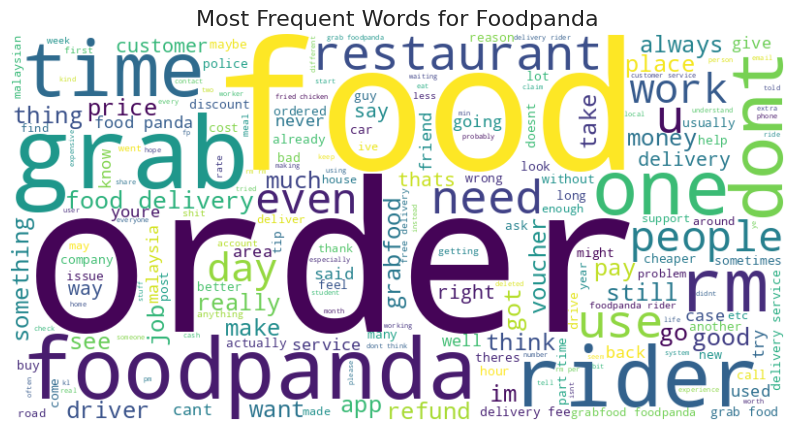

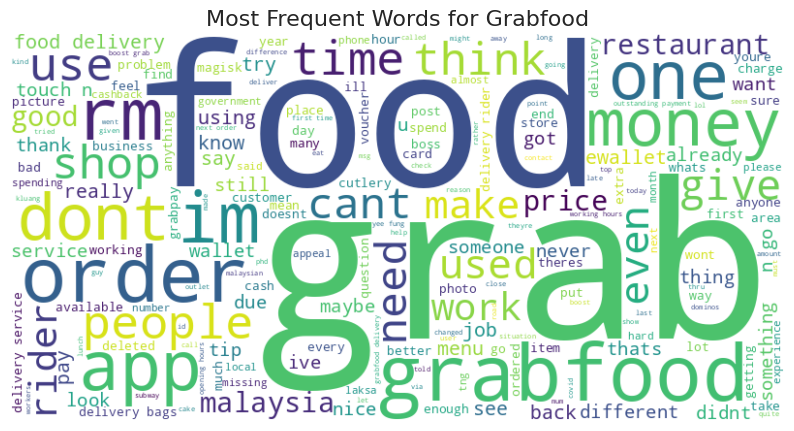

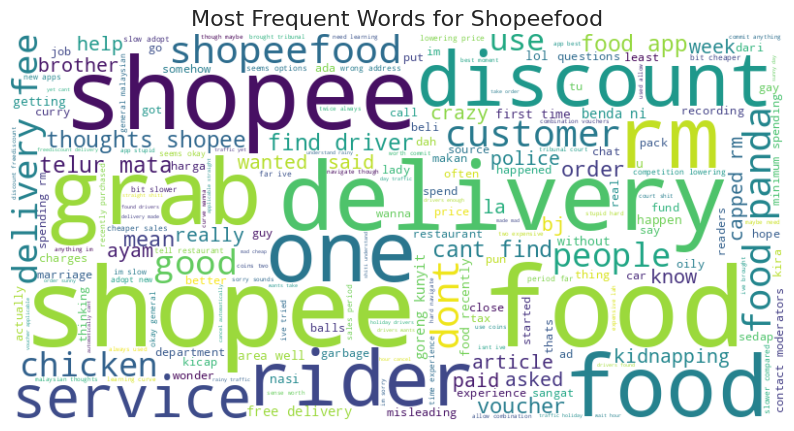

In [57]:
# Word Cloud for each OFD
for ofd in ofds:
    ofd_data = absa_df[absa_df['related_ofd'] == ofd]
    text = ' '.join(ofd_data['original_text'].dropna())

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Frequent Words for {ofd.capitalize()}', fontsize=16)
    plt.show()

